## MASK CNN

In [14]:
# https://github.com/matterport/Mask_RCNN    
import cv2 
import argparse
import numpy as np
import os.path
import sys
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [19]:
# Draw the predicted bounding box, colorize and show the mask on the image

def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # mask 15ㅌ15를 resize
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    # frame은 원본영상 mask에 해당하는 원본만 가져온다.
    roi = frame[top:bottom+1, left:right+1][mask]

    # 후처리
    # 원본 픽셀(0.3) 과 segmentation 픽셀 비율(0.7)을 가져와서 더한다
    # opencv는 이렇게 밖에 못한다.
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]                 # mask 가중치    
    frame[top:bottom+1, left:right+1][mask] = ([0.7*color[0], 0.7*color[1], 0.7*color[2]] + 0.3 * roi).astype(np.uint8)

    
def postprocess(boxes, masks):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]  # 7개 정보  ?, classid, score, left, top 
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            # mask의 위치정보를 모른다, 박스의 위치로 확장시켜서 안다 15x15를 mask에 맞게 resize시켜서 보여준다.
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)



In [20]:
classesFile = "../datas/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

textGraph = "../datas/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "../datas/frozen_inference_graph.pb"   # 다운받아야 함

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "../datas/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

print(classes)
print(colors)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
[array([  0., 255.,   0.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255

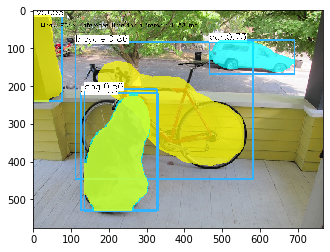

In [23]:
frame = cv2.imread('../datas/dog1.jpg')

blob = cv2.dnn.blobFromImage(frame,
                             # scale을 주지 않았다., 파란장미 , 붉은 장미 구분시에는 TRUE
                             swapRB=True, crop=False)
net.setInput(blob)

# 하나는 검출과 관련 하나는 segmentaion과 관련된 layer
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

cv2.imwrite("output.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.         7.         0.42450282 0.6093582  0.12880099 0.90505886
 0.2896334 ]
7


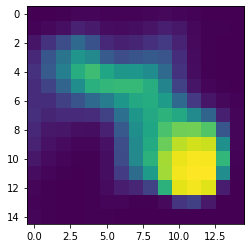

In [24]:
print(boxes.shape)   # 1,1,100box,7개 정보
print(masks.shape)   # 100개box, 90개클래스, mask # mask 크기는 15x15으로 영상크기가 어떻든..

# 7개 정보 : ?, classid, score, left, top
print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print(id)

m = masks[0,id, :,:]
plt.imshow(m)